<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/SFEW_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps
1. Libraries
2. Dataset - read | create | show example
3. Dataloader - show example
4. Transforms - Normalize
5. Model - summary, pre-trained
6. Train Function
7. Test Function

- Iteration 1
  - Frozen weights, only changing the number of classes (validation accuracy ~25%)
- Iteration 2
  - Training - One Cycle LR (validation accuracy ~25%)
- Iteration 3
  - Changing weights of the backbone network (validation accuracy ~25%)
- Iteration 4
  - Including view of LR
  - Changing model to remove ReLU and BN in last layer
- Iteration 5 (next)
  - Image Augmentation
  - GradCAM

In [1]:
!pip install torch-summary

In [2]:
# importing libraries
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
from torch.utils.data import DataLoader, Dataset
import os
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## DataSet
We are using SFEW dataset, which contains ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] classes



In [4]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_PATH = '/content/drive/MyDrive/sfew'
EXTRACT_BASE_PATH = '/content/sample_data'
EXTRACT_DIR = os.path.join(EXTRACT_BASE_PATH,'sfew')
if not os.path.exists(EXTRACT_DIR):
  # create directory
  os.makedirs(EXTRACT_DIR)
  print(f'Directory {EXTRACT_DIR} created successfully.')
else:
    print(f'Directory {EXTRACT_DIR} already exists.')

Directory /content/sample_data/sfew created successfully.


In [6]:
# extracting data into EXTRACT_DIR
# Open the zip file
ZIP_FILE_PATH = os.path.join(BASE_PATH,'SFEW_2.zip')
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # printing all the contents of the zip file
    zip_ref.printdir()
    # Extract all files to the specified directory
    zip_ref.extractall(EXTRACT_DIR)
print("File extraction complete.")

File Name                                             Modified             Size
Test/SFEW_2_Test.zip                           2015-07-08 14:11:20    199060703
Test/Test_Aligned_Faces.zip                    2015-07-08 12:20:40     11029890
Test/Test_Aligned_Points.zip                   2015-07-08 12:55:12       248998
Test/Test_LPQ_Features.zip                     2015-07-08 12:22:44       467744
Test/Test_PHOG_Features.zip                    2015-07-08 12:19:32      7259705
Train/Angry.zip                                2015-05-17 00:14:22     96754962
Train/Disgust.zip                              2015-05-17 12:41:38     32233965
Train/Fear.zip                                 2015-05-17 13:06:54     41873696
Train/Happy.zip                                2016-10-12 17:15:44    119766884
Train/Neutral.zip                              2015-05-17 02:07:38     82149409
Train/Sad.zip                                  2015-05-17 12:25:48    101196826
Train/Surprise.zip                      

In [7]:
labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [8]:
# finding directories after unzip in EXTRACT_DIR
print(os.listdir(EXTRACT_DIR))
dict_dataset = {'TRAIN_DIR' : os.path.join(EXTRACT_DIR,'Train'),
                'TEST_DIR' : os.path.join(EXTRACT_DIR,'Test'),
                'VAL_DIR' : os.path.join(EXTRACT_DIR,'Val')}

for dir_name, dir in dict_dataset.items():
  for zips in os.listdir(dir):
    temp_file_name = (zips).split(".")[0]
    if temp_file_name in labels:
      print (dir, zips, temp_file_name)
      with zipfile.ZipFile(os.path.join(dir,zips), 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'...completed for {dir}/{zip}')


['Train', 'Test', 'Val']
/content/sample_data/sfew/Train Fear.zip Fear
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Surprise.zip Surprise
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Happy.zip Happy
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Sad.zip Sad
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Neutral.zip Neutral
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Disgust.zip Disgust
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Angry.zip Angry
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Val Fear.zip Fear
...completed for /content/sample_data/sfew/Val/<class 'zip'>
/content/sample_data/sfew/Val Surprise.zip Surprise
...completed for /content/sample_

In [9]:
# ## creating a dataset without transforms to understand mean and std deviation.
# train_pre_norm_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
#                        transform=transforms.ToTensor())
# print(f'Number of images in train_ds: {len(train_pre_norm_ds)}')

In [10]:
import torch

def compute_mean_std(dataset):
    # Initialize variables
    mean = torch.zeros(3)  # Assuming RGB images (3 channels)
    std = torch.zeros(3)

    # Iterate over the dataset
    for sample in dataset:
        image = sample[0]  # Access the image from the sample
        mean += torch.mean(image, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(image, dim=(1, 2))  # Compute standard deviation along height and width dimensions

    # Divide by the number of samples
    mean /= len(dataset)
    std /= len(dataset)

    return mean, std

# Assuming you have a dataset object 'dataset' (e.g., ImageFolder or custom dataset)
# mean, std = compute_mean_std(train_pre_norm_ds)

# print("Mean:", mean)
# print("Standard Deviation:", std)

In [11]:
# def get_mean_std_dev(dataset):
#   '''
#   get mean and std deviation of dataset
#   '''
#   loader = DataLoader(dataset,
#                       batch_size = 1,
#                       num_workers=1,
#                       shuffle = False)
#   mean, std, num_samples = 0.0, 0.0, 0.0
#   for images, _ in loader:
#     batch_size = images.size(0)
#     images = images.view(batch_size, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     num_samples += batch_size

#   mean /= num_samples
#   std /= num_samples
#   print("Mean:", mean) # Mean: tensor([0.2197, 0.1858, 0.1569])
#   print("Standard Deviation:", std) # Mean: tensor([0.2197, 0.1858, 0.1569])
#   return mean.numpy(), std.numpy()

In [12]:
# mean_ds, std_dev_ds = get_mean_std_dev(train_pre_norm_ds)
# print(f'mean_ds = {mean_ds}, std_dev_ds ={std_dev_ds}')

In [13]:
# Train Phase transformations
#TODO: Use albumentations in later versions, first iteration does not include any transformations
mean_ds = [0.2197, 0.1858, 0.1569]
std_dev_ds =[0.1810, 0.1635, 0.1511]

train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_ds, std_dev_ds)
                                       ])

# Val Phase transformations
val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_ds, std_dev_ds)
                                     ])

In [14]:
# dataset
train_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=train_transforms)
val_ds = ImageFolder(root=dict_dataset['VAL_DIR'],
                       transform=val_transforms)

In [15]:
# for sample in train_pre_norm_ds:
#   print(sample[0])
#   break
for sample in train_ds:
  print(sample[0])
  break

tensor([[[-1.1921, -1.1921, -1.1705,  ..., -1.1921, -1.2138, -1.1921],
         [-1.2138, -1.2138, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.2138],
         ...,
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921]],

        [[-1.1124, -1.1124, -1.1364,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1364, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1364],
         ...,
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1364],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1364, -1.1124]],

        [[-1.0124, -1.0124, -1.0124,  ..., -1.0124, -1.0124, -1.0124],
         [-0.9865, -1.0124, -1.0124,  ..., -1

In [16]:
compute_mean_std(train_ds)
# get_mean_std_dev(train_ds)

(tensor([0.0004, 0.0004, 0.0001]), tensor([0.9862, 0.9847, 0.9825]))

In [17]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
BATCH_SIZE = 16
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = DataLoader(train_ds, **dataloader_args)

# test dataloader
val_loader = DataLoader(val_ds, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset_loader,label_names,num_images=5):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    images[i] = images[i] / 2 + 0.5 # unnormalize, though not the best way
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")

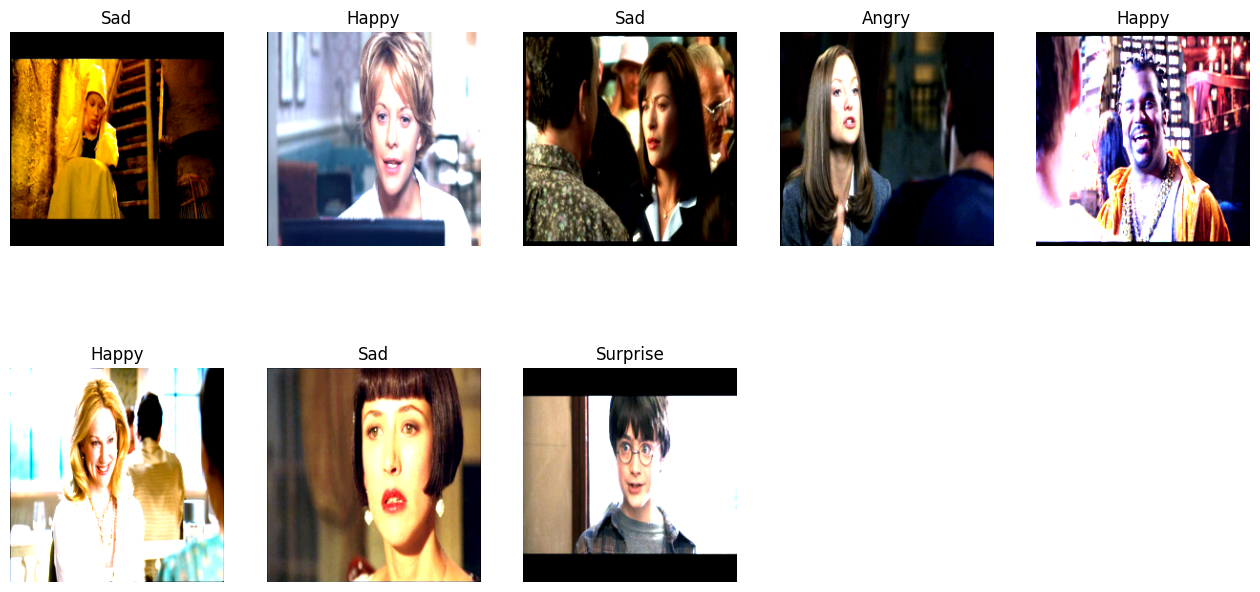

In [19]:
show_batch(train_loader,labels,8)

## Model

In [38]:
# Load pretrained resnet50 (reference: https://pytorch.org/vision/main/models.html )
model_1 = resnet50(weights=ResNet50_Weights.DEFAULT).to(device) # original model
# # summary of the model
# summary(model_1, input_size=(3, 224, 224), depth = 3)
print (model_1) # to understand names and modules of the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Iteration 1
- Use pre-trained weights, freezing weights
- No changes in feature extraction layer
- Number of output changed to the number of classes, i.e. 7

In [39]:
# Freeze model parameters
for param in model_1.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model_1.fc.in_features
model_1.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [40]:
print(model_1) # checking if the FC layer has changed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Iteration 3
- Making the weights of the model trainable

In [41]:
# Freeze model parameters
for param in model_1.parameters():
    param.requires_grad = True

### Iteration 4
- Changing the ReLU in last Conv Layer to Identity()
- Changing the batchNorm in the last Conv Layer
Reference: https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591/4


In [42]:
model_1.layer4[2].relu = nn.Identity()
model_1.layer4[2].bn3 = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)

In [43]:
print(model_1) # checking if the ReLU and BN in layer 4 has changed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### One Cycle Policy

### Iteration 2
- Use of One Cycle Policy to understand the best learning rate
- Best Validation accuracy in 20 epochs was Accuracy: 112/436 (25.69%)
- Assume number of epoch to be 20 (to be changed later)

In [44]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [45]:
import copy
model_oclr = copy.deepcopy(model_1)
model_oclr = model_oclr.to(device)


# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9) # SGD is good for CV task #TODO : Try Adam

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.52E-03


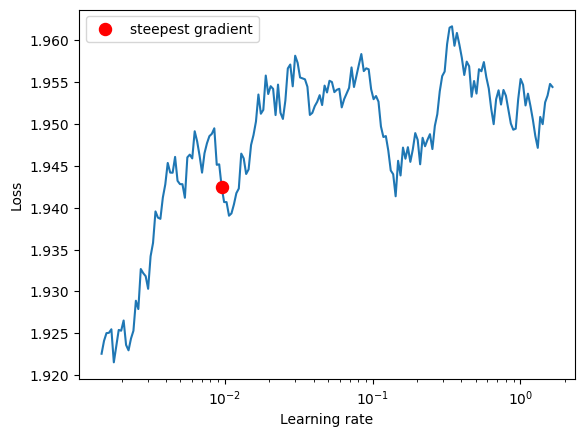

0.009521323812208146


In [46]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm


lr_finder = LRFinder(model_oclr, optimizer, loss_func, device="cuda")
lr_finder.range_test(train_loader, end_lr=2, num_iter=200,step_mode = "exp")
_, best_lr = lr_finder.plot() # to inspect the loss-learning rate graph
print(best_lr)
lr_finder.reset() # to reset the model and optimizer to their initial state

In [47]:
model_1 = model_1.to(device)

In [48]:
max_lr = best_lr
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9) # SGD is good for CV task #TODO : Try Adam
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=(5/EPOCHS),## how much percent of cycle to use for building up
                                                div_factor=100,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation
                                                final_div_factor=100,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                )

## Train

In [49]:

from tqdm import tqdm
import torch
import torch.nn as nn


def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels).sum().item()


def train(model, device, train_loader, optimizer, criterion, scheduler=None):
    """
    Function to train model on the training dataset
    :param model: Model architecture
    :param device: Device on which training is to be done (GPU/CPU)
    :param train_loader: DataLoader for training dataset
    :param optimizer: Optimization algorithm to be used for updating weights
    :param criterion: Loss function for training
    :param scheduler: Scheduler for learning rate
    """
    # Enable layers like Dropout for model training
    model.train()

    # Utility to display training progress
    pbar = tqdm(train_loader)

    # Variables to track loss and accuracy during training
    train_loss = 0
    correct = 0
    processed = 0

    # Iterate over each batch and fetch images and labels from the batch
    for batch_idx, (data, target) in enumerate(pbar):

        # Put the images and labels on the selected device
        data, target = data.to(device), target.to(device)

        # Reset the gradients for each batch
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Use learning rate scheduler if defined
        if scheduler:
            scheduler.step()

        # Get total number of correct predictions
        correct += get_correct_predictions(pred, target)
        processed += len(data)

        # Display the training information
        pbar.set_description(
            desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')

    return correct, processed, train_loss


def test(model, device, test_loader, criterion):
    """
    Function to test the model training progress on the test dataset
    :param model: Model architecture
    :param device: Device on which training is to be done (GPU/CPU)
    :param test_loader: DataLoader for test dataset
    :param criterion: Loss function for test dataset
    """
    # Disable layers like Dropout for model inference
    model.eval()

    # Variables to track loss and accuracy
    test_loss = 0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_predictions(output, target)

    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return correct, test_loss


def get_lr(optimizer):
    """
    Function to track learning rate while model training
    :param optimizer: Optimizer used for training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [50]:
# import torch
# import torch.nn as nn
# from tqdm import tqdm # for beautiful model training updates


# def trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler):
#   train_losses = [] # to capture train losses over training epochs
#   train_accuracy = [] # to capture train accuracy over training epochs
#   test_losses = [] # to capture test losses
#   test_accuracy = [] # to capture test accuracy
#   learning_rates = [] # to capture learning rate
#   for epoch in range(epochs):
#     print("EPOCH:", epoch+1)
#     train(model, device, trainloader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler) # Training Function
#     learning_rates.append(get_lr(optimizer))
#     test(model, device, testloader,criterion,test_accuracy,test_losses)   # Test Function

#   return train_accuracy, train_losses, test_accuracy, test_losses, learning_rates


# def get_lr(optimizer):
#     """
#     Function to track learning rate while model training
#     :param optimizer: Optimizer used for training
#     """
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# # # Training Function
# def train(model, device, train_loader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler = None):
#   model.train() # setting the model in training
#   pbar = tqdm(train_loader) # putting the iterator in pbar
#   correct = 0 # for accuracy numerator
#   processed =0 # for accuracy denominator

#   for batch_idx, (images,labels) in enumerate(pbar):
#     images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
#     optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#     y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
#     # the predictions are in one hot vector

#     loss = criterion(y_preds,labels) # capturing loss

#     train_losses.append(loss) # to capture loss over many epochs

#     loss.backward() # backpropagation
#     optimizer.step() # updating the params

#     if scheduler:
#       if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#         scheduler.step()

#     preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += preds.eq(labels.view_as(preds)).sum().item()
#     processed += len(images)


#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

#     train_accuracy.append(100*correct/processed)


# # # Test Function
# def test(model, device, test_loader,criterion,test_accuracy,test_losses) :
#   model.eval() # setting the model in evaluation mode
#   test_loss = 0
#   correct = 0 # for accuracy numerator

#   with torch.no_grad():
#     for (images,labels) in test_loader:
#       images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
#       outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
#       # the outputs are in batch size x one hot vector

#       test_loss = criterion(outputs,labels).item()  # sum up batch loss
#       preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#       correct += preds.eq(labels.view_as(preds)).sum().item()

#     test_loss /= len(test_loader.dataset) # average test loss
#     test_losses.append(test_loss) # to capture loss over many batches

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#     test_loss, correct, len(test_loader.dataset),
#     100. * correct / len(test_loader.dataset)))

#     test_accuracy.append(100*correct/len(test_loader.dataset))

In [51]:
#  train_accuracy, train_losses, test_accuracy, test_losses, learning_rates = trainer(model = model_1,
#                                                                     device = device,
#                                                                     trainloader = train_loader,
#                                                                     testloader = val_loader,
#                                                                     optimizer = optimizer,
#                                                                     epochs = EPOCHS,
#                                                                     criterion = loss_func,
#                                                                     scheduler= None)

In [52]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [53]:
# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model_1, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model_1, device, val_loader, criterion)
    test_acc.append(100. * correct / len(val_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.8337 Batch_id=59 Accuracy=19.21: 100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Test set: Average loss: 0.1220, Accuracy: 75/436 (17.20%)

Epoch 2


Train: Loss=1.9234 Batch_id=59 Accuracy=26.83: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Test set: Average loss: 0.1289, Accuracy: 78/436 (17.89%)

Epoch 3


Train: Loss=2.1972 Batch_id=59 Accuracy=33.82: 100%|██████████| 60/60 [00:11<00:00,  5.05it/s]


Test set: Average loss: 0.1281, Accuracy: 88/436 (20.18%)

Epoch 4


Train: Loss=1.7247 Batch_id=59 Accuracy=44.36: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


Test set: Average loss: 0.1349, Accuracy: 73/436 (16.74%)

Epoch 5


Train: Loss=1.7634 Batch_id=59 Accuracy=47.08: 100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


Test set: Average loss: 0.1337, Accuracy: 95/436 (21.79%)

Epoch 6


Train: Loss=0.9832 Batch_id=59 Accuracy=55.43: 100%|██████████| 60/60 [00:11<00:00,  5.34it/s]


Test set: Average loss: 0.1461, Accuracy: 85/436 (19.50%)

Epoch 7


Train: Loss=0.8044 Batch_id=59 Accuracy=64.51: 100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


Test set: Average loss: 0.1343, Accuracy: 125/436 (28.67%)

Epoch 8


Train: Loss=0.4324 Batch_id=59 Accuracy=73.17: 100%|██████████| 60/60 [00:11<00:00,  5.08it/s]


Test set: Average loss: 0.1544, Accuracy: 88/436 (20.18%)

Epoch 9


Train: Loss=0.4245 Batch_id=59 Accuracy=81.42: 100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


Test set: Average loss: 0.1527, Accuracy: 109/436 (25.00%)

Epoch 10


Train: Loss=0.3905 Batch_id=59 Accuracy=84.86: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


Test set: Average loss: 0.1649, Accuracy: 117/436 (26.83%)

Epoch 11


Train: Loss=0.4400 Batch_id=59 Accuracy=90.71: 100%|██████████| 60/60 [00:11<00:00,  5.07it/s]


Test set: Average loss: 0.1727, Accuracy: 115/436 (26.38%)

Epoch 12


Train: Loss=0.0662 Batch_id=59 Accuracy=93.11: 100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


Test set: Average loss: 0.2060, Accuracy: 107/436 (24.54%)

Epoch 13


Train: Loss=0.1970 Batch_id=59 Accuracy=93.53: 100%|██████████| 60/60 [00:11<00:00,  5.32it/s]


Test set: Average loss: 0.1811, Accuracy: 115/436 (26.38%)

Epoch 14


Train: Loss=0.0053 Batch_id=59 Accuracy=95.20: 100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


Test set: Average loss: 0.1838, Accuracy: 131/436 (30.05%)

Epoch 15


Train: Loss=0.5892 Batch_id=59 Accuracy=96.66: 100%|██████████| 60/60 [00:11<00:00,  5.39it/s]


Test set: Average loss: 0.1694, Accuracy: 118/436 (27.06%)

Epoch 16


Train: Loss=0.2881 Batch_id=59 Accuracy=98.54: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s]


Test set: Average loss: 0.1826, Accuracy: 139/436 (31.88%)

Epoch 17


Train: Loss=0.1418 Batch_id=59 Accuracy=99.27: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


Test set: Average loss: 0.1807, Accuracy: 148/436 (33.94%)

Epoch 18


Train: Loss=0.0285 Batch_id=59 Accuracy=99.27: 100%|██████████| 60/60 [00:11<00:00,  5.32it/s]


Test set: Average loss: 0.1875, Accuracy: 145/436 (33.26%)

Epoch 19


Train: Loss=0.0073 Batch_id=59 Accuracy=99.27: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


Test set: Average loss: 0.1890, Accuracy: 150/436 (34.40%)

Epoch 20


Train: Loss=0.0021 Batch_id=59 Accuracy=99.37: 100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


Test set: Average loss: 0.1892, Accuracy: 133/436 (30.50%)



## Checking training and results

In [54]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")

    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")

    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")

    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")

    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

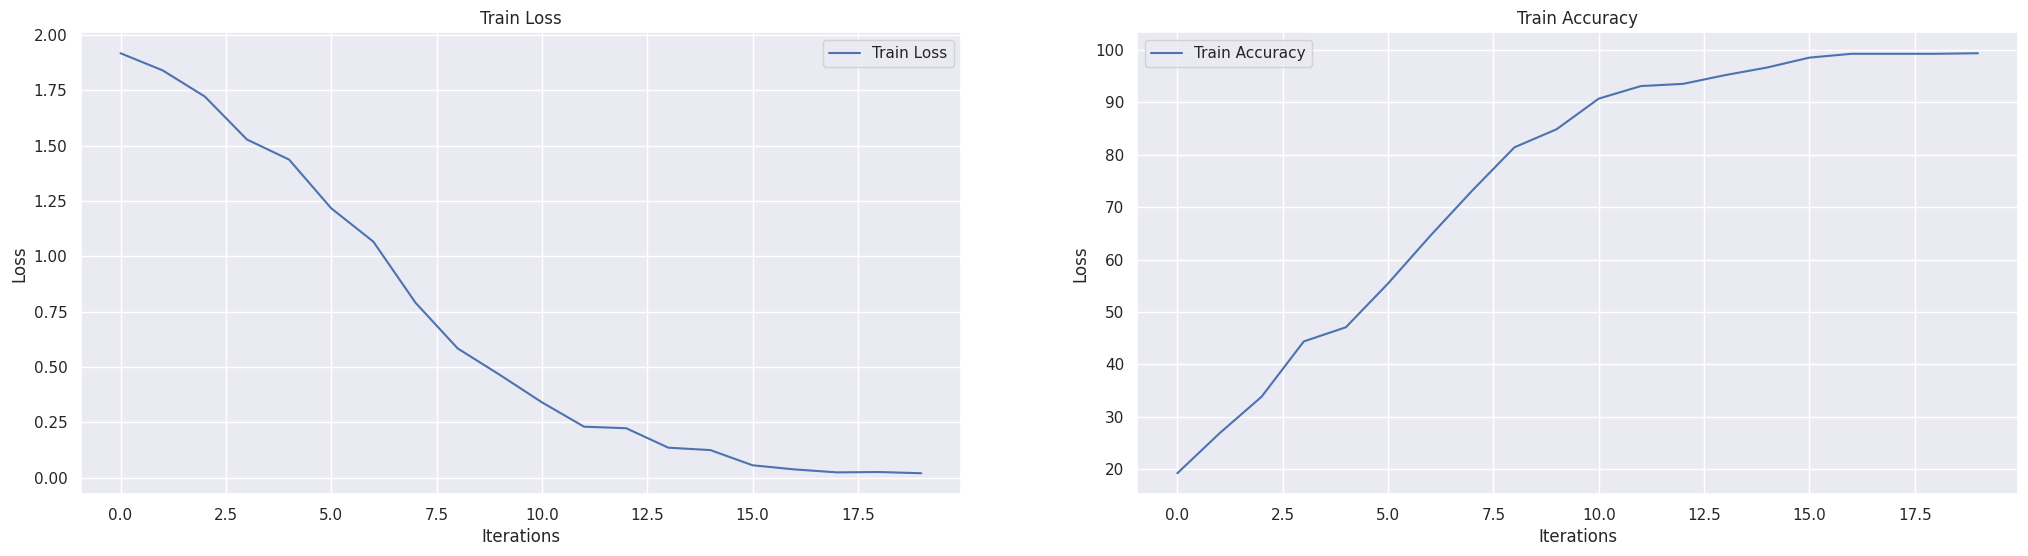

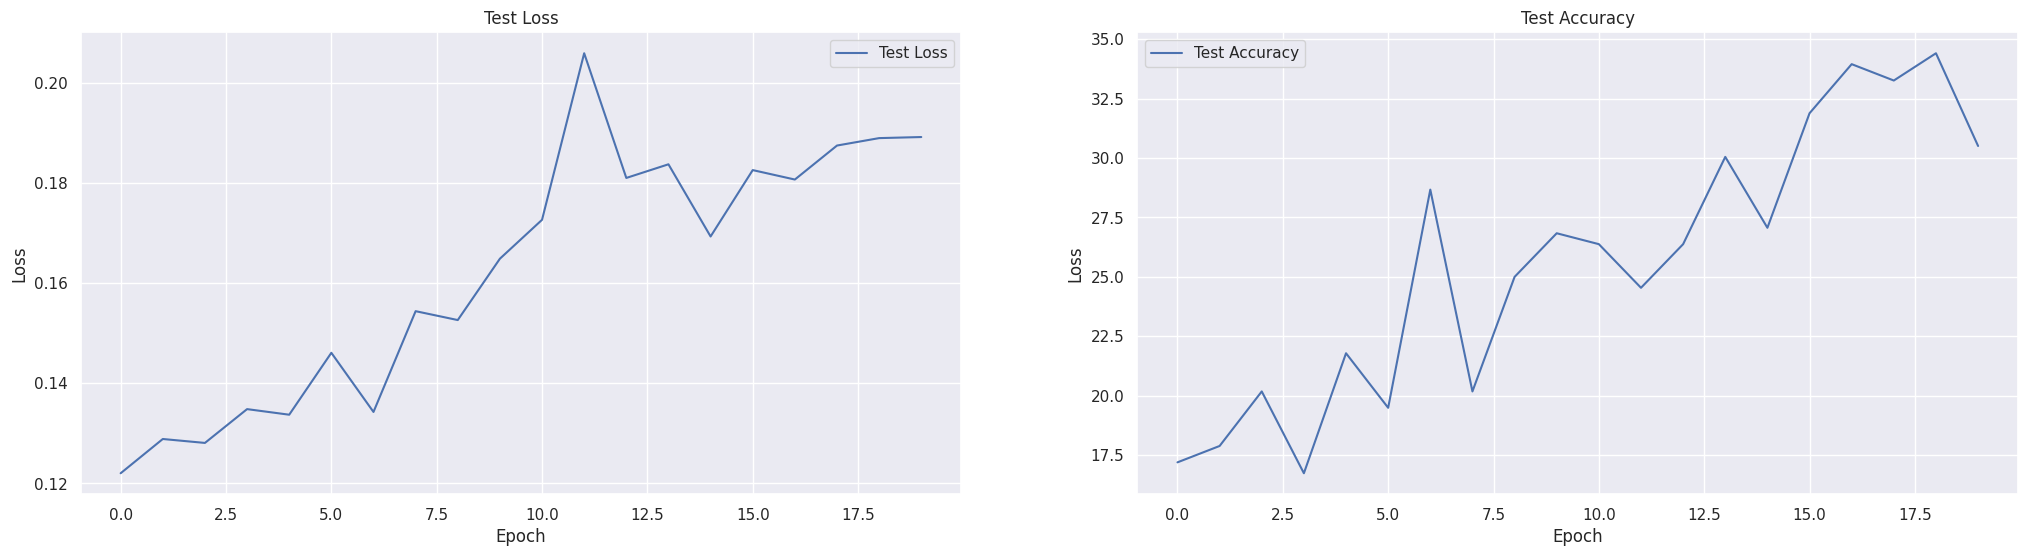

In [57]:
# plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)
plot_metrics(train_acc,train_losses, test_acc, test_losses )

Text(0.5, 1.0, 'Training Learning Rate')

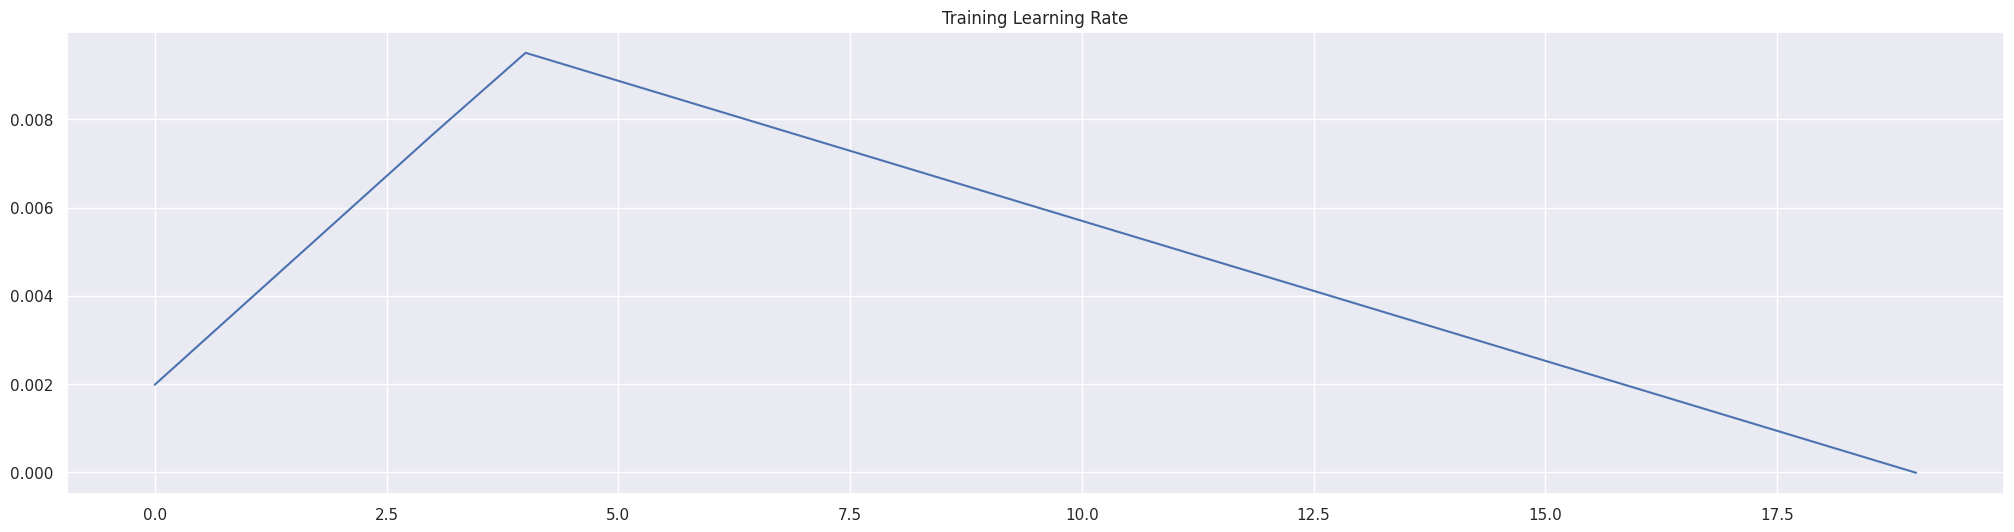

In [59]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)
plt.title("Training Learning Rate")

### Classwise accuracy

In [60]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [61]:
evaluate_classwise_accuracy(model_1, device, labels, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of Angry : 35 %
Accuracy of Disgust :  0 %
Accuracy of  Fear :  8 %
Accuracy of Happy : 40 %
Accuracy of Neutral : 47 %
Accuracy of   Sad : 23 %
Accuracy of Surprise :  5 %


### Misclassified Images

In [62]:
def plot_misclassified_images(wrong_predictions, mean, std, n_images=20, class_names=None):
    """
    Plot the misclassified images.
    """
    if class_names is None:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    fig = plt.figure(figsize=(10, 12))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:n_images]):
        img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
        for j in range(img.shape[0]):
            img[j] = (img[j] * std[j]) + mean[j]

        img = np.transpose(img, (1, 2, 0))
        ax = fig.add_subplot(5, 5, i + 1)
        ax.axis("off")
        ax.set_title(f"\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}", fontsize=10)
        ax.imshow(img)

    plt.show()

def misclassified_images(model, test_loader, device, mean, std, class_names=None, n_images=20):
    """
    Get misclassified images.
    """
    wrong_images = []
    wrong_label = []
    correct_label = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = pred.eq(target.view_as(pred)) == False
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])

            wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
        print(f"Total wrong predictions are {len(wrong_predictions)}")

        plot_misclassified_images(wrong_predictions, mean, std, n_images=n_images, class_names=class_names)

    return wrong_predictions



Total wrong predictions are 292


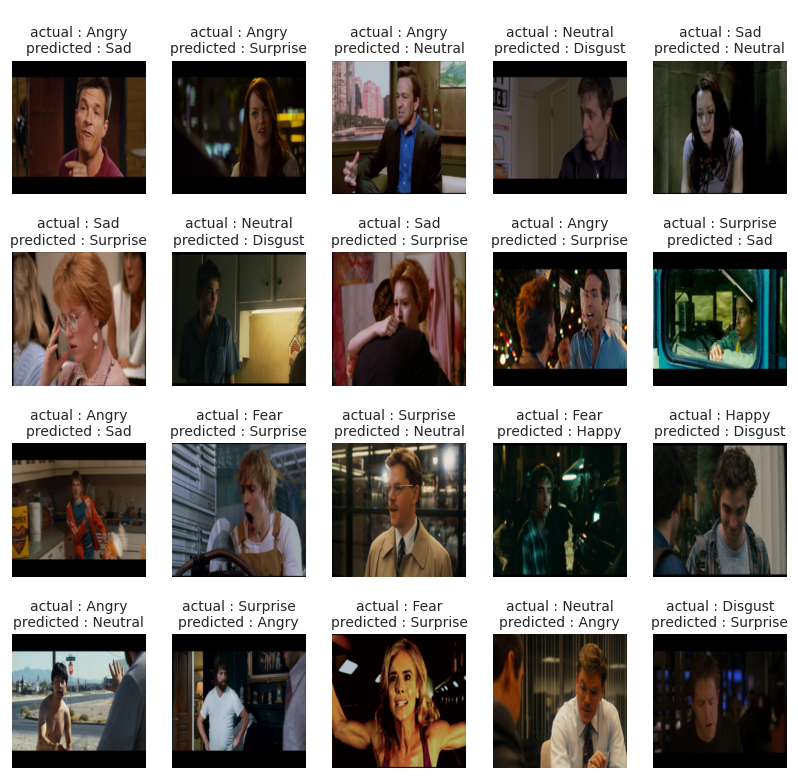

In [63]:
images_misclassified = misclassified_images(model_1, val_loader, device, mean_ds, std_dev_ds , class_names=labels)